<a href="https://colab.research.google.com/github/chebbal/data-centric-deep-learning/blob/main/week1/Copy_of_Data_Quality_Inter_Annotator_Agreement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Quality: Inter-Annotator Agreement

> DUPLICATE THIS COLAB TO START WORKING ON IT. Using File > Save a copy to drive.

## Overview

In this notebook, we will focus on measuring the quality of annotations. Recall from the course notes that because we can't exactly compute the accuracy of annotations (we have no ground truth), we settle for computing the reliability of annotations: how consistent are annotators with each other? We use this measure of agreement as a proxy for a measure of quality. 

## Goals

The main goal is to understand how to write code to compute inter-annotator agreement. In particular, we will
- Study annotation within two different domains: classification and object detection.
- Learn how to code Cohen's Kappa, a measure of agreement that takes into account the probability of agreement under guessing.
- Learn how to implement the *Intersection over Union* metric, or IoU.

## Instructions

1. We provide starter code and data to give your work a common starting point and scaffolding. You should try to keep function signatures unchanged to support any later usage or grading of your project.
1. Ensure you read through the document and starting code before beginning your work. Understand the overall structure and goals of the project to make your implementation efficient. 

# Dependencies

In [1]:
import json
import numpy as np
from math import isclose
from sklearn.metrics import cohen_kappa_score

# Classification

Let's start with binary classification, which we know and love from sentiment analysis. In the reading, we learned about Cohen's kappa, a score measuring the level of agreement between two annotators that accounts for the probability of randomly agreeing with one another. 

### Why do we use Cohen's kappa instead of just measuring agreement directly? 

Let's find out using a simulation! Let's pretend to be annotator 1 and we will generate their labels randomly. Let's say class 0 occurs roughly 90% of the time. So we can produce a random number between 0 and 1 one thousand times and set the annotation to 1 if the number is greater than 0.9, otherwise set the annotation to 0.

In [2]:
np.random.seed(42)

# randomly generate annotator one's labels
annotations1 = np.random.rand(1000) > 0.9

For annotator two, we simulate some error but flipping half of the labels where annotator one gave a positive label.

In [3]:
annotations2 = np.copy(annotations1)

# find where annotator one predicted positive
indices = np.where(annotations2 == 1)[0]
indices = np.random.choice(indices, size=int(len(indices) / 2))

# flip half of them!
annotations2[indices] = 1 - annotations2[indices]

Let's compute the raw agreement just as average accuracy between the two annotators.

In [4]:
acc_agreement = float(np.mean(annotations1 == annotations2))
print(f'Agreement in Accuracy: {acc_agreement}')

Agreement in Accuracy: 0.963


Wow! 96% agreement is pretty good between annotators, right? Let's see what Cohen's Kappa says (using `scikit-learn`).

In [5]:
kappa_agreement = cohen_kappa_score(annotations1, annotations2)
print(f'Agreement in Cohen\'s Kappa: {kappa_agreement}')

Agreement in Cohen's Kappa: 0.7539893617021276


Wait, this is a lot lower. 75% agreement is much less acceptable of a level of agreement for practical applications. Why is Cohen's Kappa so low whereas accuracy is so high? 

It's because the expected agreement of annotators guessing each class is very skewed. Consider:


In [6]:
num_zero_1 = np.sum(annotations1 == 0)
num_one_1 = np.sum(annotations1 == 1)

num_zero_2 = np.sum(annotations2 == 0)
num_one_2 = np.sum(annotations2 == 1)

print(f'Annotator 1 labeled {num_zero_1} zeros and {num_one_1} ones.')
print(f'Annotator 2 labeled {num_zero_2} zeros and {num_one_2} ones.')

Annotator 1 labeled 900 zeros and 100 ones.
Annotator 2 labeled 937 zeros and 63 ones.


Looks like both annotators are very biased towards labeling class zero meaning that purely competing accuracy is over-optimistic on the agreement: a lot of the time, annotator one and two likely just agree by chance. Cohen's Kappa accounts for the bias to class zero. 

### Let's implement it!

To compute Cohen's Kappa, we need to compute two terms: `p_0` and `p_e`. 
Let `p_0` be the observed agreement between rater i.e. what fraction of the time did annotators one and two agree? This is just like computing accuracy as we did above. 

Let `p_e` be the probability of chance agreement. This slightly trick to compute. First, let `p_e = p_e1 + p_e2` where `p_e1 = n1 * m1 / N^2` where `N` is the total number of examples (for us 1000), and `n1` is the number of times annotator 1 predicted class 1 and `m1` is the number of times annotator 2 predicted class 1. Similarly `p_e2 = n2 * m2 / N^2` where `n2` is the number of times annotator 1 predicted class 2. And so on... See [Wikipedia](https://en.wikipedia.org/wiki/Cohen%27s_kappa) for a great summary.

In [7]:
def our_cohen_kappa_score(y1, y2):
  r"""Cohen’s kappa: a statistic that measures inter-annotator agreement.

  This function computes Cohen’s kappa [1], a score that expresses the level 
  of agreement between two annotators on a classification problem. 

  Arguments
  ---------
  y1 (array): labels assigned by first annotator.
  y2 (array): labels assigned by second annotator.

  Returns
  -------
  kappa: float (between -1 and 1)
  """
  assert y1.shape[0] == y2.shape[0], "Size is not the same."
  p0 = None
  pe = None
  
  # this is total length of `y1`
  N = float(y1.shape[0])
  # example of how to compute `n1` and `m1` (class 0)
  # you will need to add similar variables for class 1
  n1 = np.sum(y1 == 0)
  m1 = np.sum(y2 == 0)

  # ==========================
  # FILL ME OUT
  # Compute p0 and pe as described above.
  # 
  # Pseudocode:
  # --
  # p0 = ...
  # n2 = ...
  # m2 = ...
  # pe = ...
  # 
  # Type:
  # --
  # p0: float
  # n2: float
  # m2: float
  # pe: float
  # ==========================
  p0 = np.mean(y1 == y2)
  n2 = np.sum(y1 == 1)
  m2 = np.sum(y2 == 1)
  pe = (n1 * m1 + n2 * m2) / N**2
  kappa = (p0 - pe) / (1.0 - pe)
  return kappa

We can test our implementation by comparing to scikit-learn's implementation.

In [8]:
our_kappa = our_cohen_kappa_score(annotations1, annotations2)
scikit_kappa = cohen_kappa_score(annotations1, annotations2)

print(f'Our kappa: {our_kappa} | Scikit-Learn kappa: {scikit_kappa}')
assert isclose(our_kappa, scikit_kappa), "Not close... next time!" 

Our kappa: 0.7539893617021274 | Scikit-Learn kappa: 0.7539893617021276


---

# Object Detection: Intersection over Union

Recall from the reading that for object detection, the annotations are bounding boxes that specify a `(x,y)` coordinate along with a height `h` and a width `w`. To measure agreement, we will implement IoU. You might be wondering: is there such a thing as Cohen's Kappa for IoU? In practice, this isn't used  because the random chance of selecting the right bounding box out of all possible bounding boxes is neglible. 

In [9]:
!gdown --id 1-IBa5lOggQQ558m5ElChN6WUC3m63ncW
!gdown --id 1cpszI376NlM3yEGyaaC9WsMkTacEebzK
!unzip -o images.zip

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1-IBa5lOggQQ558m5ElChN6WUC3m63ncW
To: /content/images.zip
100% 4.63M/4.63M [00:00<00:00, 143MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1cpszI376NlM3yEGyaaC9WsMkTacEebzK
To: /content/bbox-anno.json
100% 26.9k/26.9k [00:00<00:00, 35.0MB/s]
Archive:  images.zip
   creating: images/
  inflating: __MACOSX/._images       
  inflating: images/.DS_Store        
  inflating: __MACOSX/images/._.DS_Store  
  inflating: images/39.png           
  inflating: __MACOSX/images/._39.png  
  inflat

In [10]:
!ls images   # there are 10 images!

31.png	32.png	33.png	34.png	35.png	36.png	37.png	38.png	39.png	40.png


Let's check out the annotations file!

In [11]:
with open('./bbox-anno.json', 'r') as fp:
  annotations = json.load(fp)
print(f'There are {len(annotations)} annotations, two for each image.')

There are 20 annotations, two for each image.


Each annotations is a complex data structure. Let's focus on a few attributes. 

In [12]:
annotation = annotations[0]        # grab the first annotation
annotation_id = annotation['id']   # {annotation_id}.png will be the filename
print(f'{annotation_id}.png')

40.png


Each annotation could contain many bounding boxes if there are multiple objects in the scene!

In [13]:
annotation

{'annotation_id': 337,
 'annotator': 1,
 'created_at': '2022-04-12T05:07:03.211439Z',
 'id': 40,
 'image': '/data/upload/5/ecc384b0-maksssksksss337.png',
 'label': [{'height': 10.75,
   'original_height': 400,
   'original_width': 246,
   'rectanglelabels': ['with_mask'],
   'rotation': 0,
   'width': 17.073170731707318,
   'x': 41.86991869918699,
   'y': 5.75}],
 'lead_time': 3.984,
 'updated_at': '2022-04-12T05:07:03.211467Z'}

In [14]:
labels = annotation['label']
print(f'Number of annotated bounding boxes: {len(labels)}')

Number of annotated bounding boxes: 1


Here's what an annotation looks like. As you might have expected, there is a `x`, `y`, `width` and `height`. You can ignore the rest of the fields. 

In [15]:
labels[0]

{'height': 10.75,
 'original_height': 400,
 'original_width': 246,
 'rectanglelabels': ['with_mask'],
 'rotation': 0,
 'width': 17.073170731707318,
 'x': 41.86991869918699,
 'y': 5.75}

Before we get to the code, let's visualize a few of these!

In [16]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

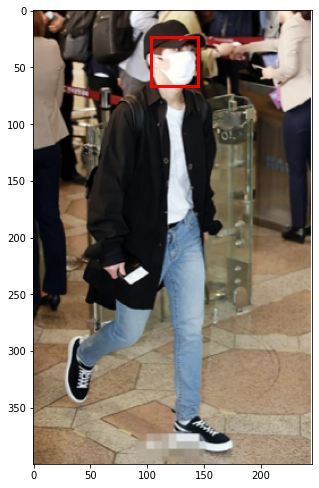

In [17]:
im = Image.open(f'images/{annotation_id}.png')

fig, ax = plt.subplots(figsize=(5, 10))
ax.imshow(im)  # viz image

labels = annotation['label']
for bbox in labels:
  # the data stored in `x`, `y`, `width`, and `height` are percentages from 
  # 0-100, meaning to get the actual coordinates, we need to multiple them by
  # the original height or width.
  x = bbox['x'] / 100. * bbox['original_width']
  y = bbox['y'] / 100. * bbox['original_height']
  w = bbox['width'] / 100. * bbox['original_width']
  h = bbox['height'] / 100. * bbox['original_height']
  rect = patches.Rectangle((x, y), w, h, linewidth=3, 
                            edgecolor='r', facecolor='none')
  ax.add_patch(rect)
plt.show()

We can also visualize the second annotation on the same image.

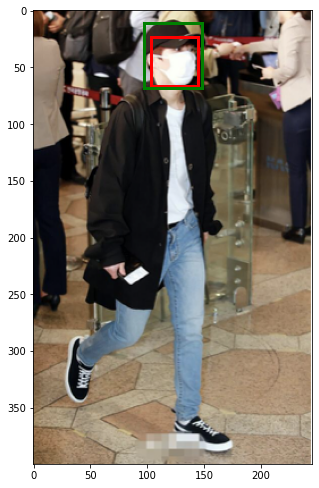

In [18]:
im = Image.open(f'images/{annotation_id}.png')

fig, ax = plt.subplots(figsize=(5, 10))
ax.imshow(im)  # viz image

labels = annotations[0]['label']
for bbox in labels:
  x = bbox['x'] / 100. * bbox['original_width']
  y = bbox['y'] / 100. * bbox['original_height']
  w = bbox['width'] / 100. * bbox['original_width']
  h = bbox['height'] / 100. * bbox['original_height']
  rect = patches.Rectangle((x, y), w, h, linewidth=3, 
                            edgecolor='r', facecolor='none')
  ax.add_patch(rect)

labels = annotations[1]['label']
for bbox in labels:
  x = bbox['x'] / 100. * bbox['original_width']
  y = bbox['y'] / 100. * bbox['original_height']
  w = bbox['width'] / 100. * bbox['original_width']
  h = bbox['height'] / 100. * bbox['original_height']
  rect = patches.Rectangle((x, y), w, h, linewidth=3, 
                            edgecolor='g', facecolor='none')
  ax.add_patch(rect)
plt.show()

Notice how there are slightly differences in the annnotation due to interpretation. Annotator one (red) only selected the face whereas annotator two (green) included the hat, both of which are reasonable approaches!

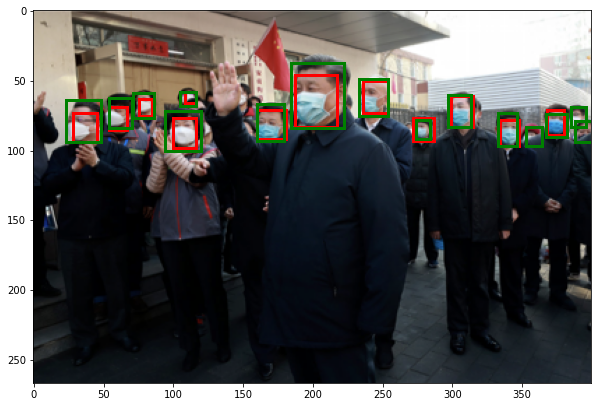

In [19]:
index = 14
im = Image.open(f'images/{annotations[index]["id"]}.png')

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(im) 

labels = annotations[index]['label']
for bbox in labels:
  x = bbox['x'] / 100. * bbox['original_width']
  y = bbox['y'] / 100. * bbox['original_height']
  w = bbox['width'] / 100. * bbox['original_width']
  h = bbox['height'] / 100. * bbox['original_height']
  rect = patches.Rectangle((x, y), w, h, linewidth=3, 
                            edgecolor='r', facecolor='none')
  ax.add_patch(rect)

# visualize the other annotator's labels
labels = annotations[index+1]['label']
for bbox in labels:
  x = bbox['x'] / 100. * bbox['original_width']
  y = bbox['y'] / 100. * bbox['original_height']
  w = bbox['width'] / 100. * bbox['original_width']
  h = bbox['height'] / 100. * bbox['original_height']
  rect = patches.Rectangle((x, y), w, h, linewidth=3, 
                            edgecolor='g', facecolor='none')
  ax.add_patch(rect)

These bounding boxes can be quite complicated! Here's an example of an image with many faces. Notice that the annotator in green captured some faces that the annotator in red did not. Computing IoU in these contexts can be more complex! Let's go through it together 💯

## Implementing IoU

Recall from the reading that IoU is computed as the intersection between two annotated bounding boxes over the union. But what if you have more than one object in a scene like the photo above? For a given bounding box provided by annotator A, compute the IoU with bounding boxes for all labels from annotator B and report the largest one! In other words, loop through all of annotator B's bounding boxes and find the one that most likely describes the same object. 

Below we provide the scaffold for the implementation of IoU with a portion for you to complete. Then, we will run it over all ten images to compute agreement between the two annotators!

In [20]:
def compute_iou(bbox1, bbox2):
  r"""Compute the IoU of two bounding boxes.

  Arguments
  ---------
  bbox1 (dict): a bounding box object.
    keys: x, y, height, width (all represent percentages)
          original_width, original_height 
  bbox2 (dict): identical to bbox1.

  Returns
  -------
  iou (float): score between 0 and 1.
  """
  # first thing to do is convert percentages to points!
  bb1 = {
      # (x1, y1) represents the top left point of the bbox
      'x1': bbox1['x'] / 100. * bbox1['original_width'],
      'y1': bbox1['y'] / 100. * bbox1['original_height'],
      # instead of height and width, we will compute the bottom right corner
      'x2': (bbox1['x'] / 100. * bbox1['original_width'] + 
             bbox1['width'] / 100. * bbox1['original_width']),
      'y2': (bbox1['y'] / 100. * bbox1['original_height'] + 
             bbox1['height'] / 100. * bbox1['original_height']),
  }
  bb2 = {
      'x1': bbox2['x'] / 100. * bbox2['original_width'],
      'y1': bbox2['y'] / 100. * bbox2['original_height'],
      'x2': (bbox2['x'] / 100. * bbox2['original_width'] + 
             bbox2['width'] / 100. * bbox2['original_width']),
      'y2': (bbox2['y'] / 100. * bbox2['original_height'] + 
             bbox2['height'] / 100. * bbox2['original_height']),
  }
  
  # sanity check!
  assert bb1['x1'] < bb1['x2']
  assert bb1['y1'] < bb1['y2']
  assert bb2['x1'] < bb2['x2']
  assert bb2['y1'] < bb2['y2']

  x_left = max(bb1['x1'], bb2['x1'])
  y_top = max(bb1['y1'], bb2['y1'])
  x_right = min(bb1['x2'], bb2['x2'])
  y_bottom = min(bb1['y2'], bb2['y2'])

  if x_right < x_left or y_bottom < y_top:
    return 0.0  # punt on unexpected result

  # area of intersection: intersection of two axis-aligned bounding boxes 
  # is itself an axis-aligned bounding box
  intersection = (x_right - x_left) * (y_bottom - y_top)

  # compute area of individual bounding boxes
  area1 = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
  area2 = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

  iou = None
  # =================================
  # FILL ME OUT
  # 
  # Use `intersection`, `area1`, and `area2` to compute IoU. Try to 
  # draw a Venn diagram to see how to compute the union from these 
  # three variables! Careful not to count the intersection twice.
  # 
  # Pseudocode:
  # --
  # iou = ...
  #
  # Type:
  # --
  # iou: float
  # =================================
  union = area1 + area2 - intersection
  iou = intersection / union
  assert iou >= 0 and iou <= 1

  return iou

Let's check the implementation on the first image we looked at above (40.png), which has only one bounding box. 

In [21]:
assert annotations[0]['id'] == 40
assert annotations[1]['id'] == 40

bbox1 = annotations[0]['label'][0]
bbox2 = annotations[1]['label'][0]

In [22]:
# if the implementation is correct, this should not raise an exception!
assert isclose(compute_iou(bbox1, bbox2), 0.6212590299277606)

Ok but now what do we do if we have multiple objects in a scene? You don't need to implement anything below but we encourage you to walk through the steps to check your understanding.

In [23]:
def compute_iou_multiple_objects(bboxes1, bboxes2):
  r"""Compute IoU given multiple objects in a scene.

  Arguments
  ---------
  bboxes1 (list[dict]): list of bounding box objects.
    keys: x, y, height, width (all represent percentages)
          original_width, original_height 
  bboxes2 (dict): identical to bboxes1.

  Returns
  -------
  avg_iou (float): score between 0 and 1 representing the 
    average iou over all objects in the scene. 
  """
  all_iou = []
  for bbox1 in bboxes1:
    cache = []
    for bbox2 in bboxes2:
      # we reuse your implementation! yay!
      cur_iou = compute_iou(bbox1, bbox2)
      cache.append(cur_iou)
    all_iou.append(max(cache))
  return float(np.mean(all_iou))

Let's try computing it on the image with lots of people in a crowd.

In [24]:
bboxes1 = annotations[14]['label']
bboxes2 = annotations[15]['label']

iou = compute_iou_multiple_objects(bboxes1, bboxes2)
assert isclose(iou, 0.6047251333091429)

Okay! amazing, we are now ready to compute average IoU agreement over all images in our mini-dataset.

In [25]:
# indices of ids for annotation 1
indices1 = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18]
ious = []  # store iou's here

for index in indices1:
  bboxes1 = annotations[index]['label']    # annotation 1's bboxes
  bboxes2 = annotations[index+1]['label']  # annotation 2's bboxes

  iou = compute_iou_multiple_objects(bboxes1, bboxes2)
  ious.append(iou)

print(f'IoU: {np.mean(ious)} +/- {np.std(ious)}')

IoU: 0.6572358954682102 +/- 0.14107067549601654


It is tempting to treat this as we would with accuracy, in which case 0.65 seems small. But IoU is a wholly different metric and an IoU over 0.5 is generally considered a good agreement. In practice, we would be quite happy with 0.65 given its healthy margin over 0.5.

# That's it folks!

Just a quite reminder of what we covered. In this notebook:

- You implemented Cohen's Kappa, an important metric for measuring agreement more fairly in classification settings. 

- You got to see bounding boxes in modern object detection settings. 

- You implemented Intersection over Union for annotations in a realistic facial bounding box task.

Great work! This is the last portion of your project for week 1. By now, you've learned a lot about annotation and what makes it both important and difficult. If you have any questions, please feel free to ask the teaching team! Otherwise, get ready for week 2 ⭐